In [19]:
import numpy as np
import pandas as pd
#!pip install rdkit
#!pip install xgboost
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import os



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

!pip install Bio
from Bio import SeqIO
import qbi_mutation_simulator_with_tsv as simulate_qbi_mutations


In [21]:
#Generating and Testing New Variants

# Specify the path to your FASTA file
fasta_file = 'reference.fasta'

# Open the file and iterate over its contents
for record in SeqIO.parse(fasta_file, 'fasta'):
    reference_fatsa_seq = str(record.seq)

    # Print the record ID and the sequence
    # print(f"ID: {record.id}")
    # print(f"Description: {record.description}")
    # print(f"Sequence: {record.seq}\n")


#Generate Variants
sequences, mutations = simulate_qbi_mutations.process_fasta(
    input_file="reference.fasta",
    mutation_prob=0.05,
    num_variants=100
    )

variant_sequences = [str(sequence.seq) for sequence in sequences]

/usr/local/lib/python3.11/dist-packages/Bio/SeqRecord.py:228: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


In [10]:
# Set RDKit to fail quietly on invalid SMILES
os.environ['RDLOGLEVEL'] = 'ERROR'

# ----------------------
# Feature Engineering
# ----------------------

def amino_acid_composition(sequence):
    """Calculate amino acid composition features"""
    aa_list = 'ACDEFGHIKLMNPQRSTVWY'
    total = len(sequence)
    return {f'aa_{aa}': (sequence.count(aa)/total) if total > 0 else 0 for aa in aa_list}

def smiles_to_features(smiles):
    """Convert SMILES to molecular features"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # Morgan fingerprint
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)

        # Molecular descriptors
        descrs = {
            'mol_weight': Descriptors.MolWt(mol),
            'logp': Descriptors.MolLogP(mol),
            'h_bond_donors': Descriptors.NumHDonors(mol),
            'h_bond_acceptors': Descriptors.NumHAcceptors(mol),
            'rotatable_bonds': Descriptors.NumRotatableBonds(mol)
        }

        return {'fingerprint': fp, 'descriptors': descrs}
    except:
        return None

# ----------------------
# Data Preparation
# ----------------------

# Load data
data = pd.read_csv("uniprotkb_rhea_49528_2025_03_09 - More Data.csv")

# Preprocessing
# Handle missing values
data.dropna(subset=['Amino Acid Sequence', 'SMILES Representation', 'KM (mM)'], inplace=True)

# ----------------------
# Feature Extraction
# ----------------------

# Process amino acid sequences
print("Processing amino acid sequences...")
aa_features = data['Amino Acid Sequence'].apply(amino_acid_composition).apply(pd.Series)
aa_features['seq_length'] = data['Amino Acid Sequence'].str.len()

# Process SMILES strings
print("Processing SMILES strings...")
smiles_features = []
valid_indices = []

for i, row in data.iterrows():
    features = smiles_to_features(row['SMILES Representation'])
    if features is not None:
        valid_indices.append(i)
        fp_array = np.array(features['fingerprint'])
        descrs = features['descriptors']
        smiles_features.append({
            **descrs,
            **{f'fp_{j}': bit for j, bit in enumerate(fp_array)}
        })
    else:
        print(f"Invalid SMILES at index {i}: {row['SMILES Representation']}")

# Filter data to valid entries
data = data.iloc[valid_indices].reset_index(drop=True)
aa_features = aa_features.iloc[valid_indices].reset_index(drop=True)
smiles_df = pd.DataFrame(smiles_features)

# Combine all features
X = pd.concat([aa_features, smiles_df], axis=1)
y = data['KM (mM)']

# ----------------------
# Train-Test Split
# ----------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----------------------
# Model Training
# ----------------------

# XGBoost with hyperparameter tuning
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

xgb = XGBRegressor(objective='reg:squarederror', n_jobs=-1)
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42
)

print("Training model...")
search.fit(X_train, y_train)

best_model = search.best_estimator_
print(f"Best parameters: {search.best_params_}")
print(f"Best CV score (MSE): {-search.best_score_:.4f}")

# ----------------------
# Evaluation
# ----------------------

y_pred = best_model.predict(X_test)

print("\nModel Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

# ----------------------
# Feature Importance
# ----------------------

importance = best_model.feature_importances_
feature_names = X.columns
sorted_idx = importance.argsort()[::-1]

print("\nTop 20 Important Features:")
for i in sorted_idx[:20]:
    print(f"{feature_names[i]}: {importance[i]:.4f}")


Processing amino acid sequences...
Processing SMILES strings...
Training model...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[21:47:47] DEPRECATION WARNING: please use MorganGenerator
[21:47:47] DEPRECATION WARNING: please use MorganGenerator
[21:47:47] DEPRECATION WARNING: please use MorganGenerator
[21:47:47] DEPRECATION WARNING: please use MorganGenerator
[21:47:47] DEPRECATION WARNING: please use MorganGenerator
[21:47:47] DEPRECATION WARNING: please use MorganGenerator
[21:47:47] DEPRECATION WARNING: please use MorganGenerator
[21:47:47] DEPRECATION WARNING: please use MorganGenerator
[21:47:47] DEPRECATION WARNING: please use MorganGenerator
[21:47:47] DEPRECATION WARNING: please use MorganGenerator
[21:47:47] DEPRECATION WARNING: please use MorganGenerator
[21:47:47] DEPRECATION WARNING: please use MorganGenerator
[21:47:47] DEPRECATION WARNING: please use MorganGenerator
[21:47:47] DEPRECATION WARNING: please use MorganGenerator
[21:47:47] DEPRECATION WARNING: please use MorganGenerator
[21:47:47] DEPRECATION WARNING: please use MorganGenerator
[21:47:47] DEPRECATION WARNING: please use MorganGenerat

Best parameters: {'colsample_bytree': 0.6431565707973218, 'learning_rate': 0.019428755706020276, 'max_depth': 9, 'n_estimators': 340, 'subsample': 0.7257423924305306}
Best CV score (MSE): 53.7533

Model Performance:
MAE: 2.4197
MSE: 11.5891
RMSE: 3.4043
R²: -0.6085

Top 20 Important Features:
fp_1: 0.1542
aa_V: 0.1427
aa_S: 0.1339
fp_11: 0.1148
aa_M: 0.0976
rotatable_bonds: 0.0565
aa_C: 0.0349
aa_F: 0.0335
aa_R: 0.0284
mol_weight: 0.0271
aa_I: 0.0230
aa_H: 0.0222
aa_T: 0.0179
logp: 0.0177
aa_E: 0.0156
aa_A: 0.0097
fp_119: 0.0085
aa_G: 0.0076
fp_14: 0.0071
aa_N: 0.0061


In [26]:
# -------------------------
# Direct Prediction Pipeline
# -------------------------
def predict_km_for_variants(variant_sequences, substrate_smiles, model):
    """Predict KM values for variant sequences and a substrate SMILES"""
    predictions = []

    # Process substrate SMILES once (since it's the same for all variants)
    sub_features = smiles_to_features(substrate_smiles)
    if not sub_features:
        raise ValueError("Invalid substrate SMILES")

    # Convert substrate features to DataFrame row
    sub_fp = np.array(sub_features['fingerprint'])
    sub_desc = sub_features['descriptors']
    sub_row = {**sub_desc, **{f'fp_{i}': bit for i, bit in enumerate(sub_fp)}}

    # Create template DataFrame with substrate features
    sub_df = pd.DataFrame([sub_row])

    # Process each variant
    for seq in variant_sequences:
        # Process amino acid features
        aa_feat = amino_acid_composition(seq)
        aa_df = pd.DataFrame([aa_feat])
        aa_df['seq_length'] = len(seq)

        # Combine with substrate features
        combined = pd.concat([aa_df.reset_index(drop=True),
                            sub_df.reset_index(drop=True)], axis=1)

        # Align columns with training data
        missing_cols = set(X.columns) - set(combined.columns)
        for col in missing_cols:
            combined[col] = 0
        combined = combined[X.columns]

        # Predict
        pred = model.predict(combined)
        predictions.append(pred[0])

    return predictions

# -------------------------
# Usage with Your Data
# -------------------------
# Your input data
new_substrate_smiles = 'C1=CC(=CC=C1C(=O)O)C(=O)OCCOC(=O)C2=CC=C(C=C2)C(=O)O'

# Get predictions
km_predictions = predict_km_for_variants(
    variant_sequences=variant_sequences,
    substrate_smiles=new_substrate_smiles,
    model=best_model
)

# Create results DataFrame
results = pd.DataFrame({
    'Variant_Sequence': variant_sequences,
    'Substrate_SMILES': new_substrate_smiles,
    'Predicted_KM(mM)': km_predictions
})

print("\nPredictions:")
print(results)

[22:58:59] DEPRECATION WARNING: please use MorganGenerator



Predictions:
                                     Variant_Sequence  \
0   MNFPRDSRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEAS...   
1   MNFPRASRLMQAAVLGGLMARSAAATAQTNPKARGPNPTAASLEAS...   
2   MNFPRASRLMQAAVLGCLMAVSAACTAWTNPFARGPNPTPASLEAS...   
3   MNFPRASRLMQPAVLGGLMAVAAAATAQTNPYARGPNPTAASLEAS...   
4   MNFPRASRLMQAAVIGCLMAVSAAATAQTNPYYTGPNPTAASLEAS...   
..                                                ...   
95  MNFPRASRLMQAAVLGGLMAVSYAATLMTNPYARGPNPTAASLEAS...   
96  MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEAS...   
97  YNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEAS...   
98  MNFPRASRLMQAAVLGGLMAQSAAVTAQTNPYARGPNPTCASLDAY...   
99  MNFPRASRLMQAAVLGGLMAVSAADTAQTNPYARGPEPTAASLEAS...   

                                     Substrate_SMILES  Predicted_KM(mM)  
0   C1=CC(=CC=C1C(=O)O)C(=O)OCCOC(=O)C2=CC=C(C=C2)...          2.253568  
1   C1=CC(=CC=C1C(=O)O)C(=O)OCCOC(=O)C2=CC=C(C=C2)...          2.197947  
2   C1=CC(=CC=C1C(=O)O)C(=O)OCCOC(=O)C2=CC=C(C=C2)...          3.054122  
3   C

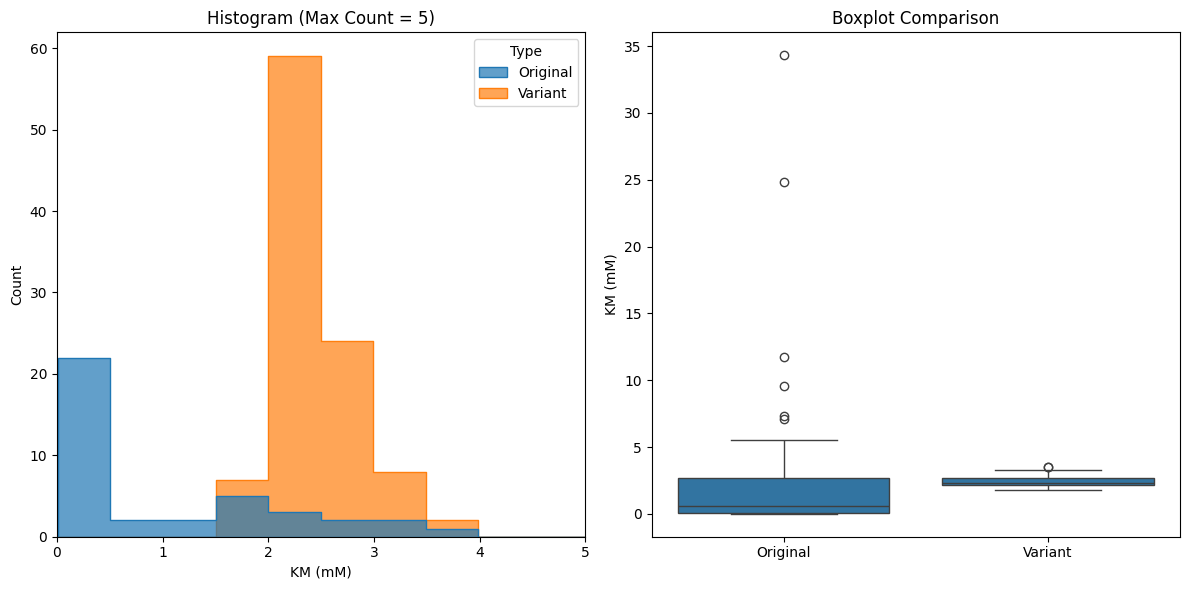

In [30]:
# ----------------------
# Updated Distribution Plot
# ----------------------
import matplotlib.pyplot as plt
import seaborn as sns

def plot_km_distributions(original_km, predicted_km):
    """
    Plot side-by-side distributions with capped y-axis
    """
    plt.figure(figsize=(12, 6))

    # Create combined DataFrame
    df = pd.DataFrame({
        'KM (mM)': np.concatenate([original_km, predicted_km]),
        'Type': ['Original'] * len(original_km) + ['Variant'] * len(predicted_km)
    })

    # Histogram plot
    plt.subplot(1, 2, 1)
    sns.histplot(
        data=df,
        x='KM (mM)',
        hue='Type',
        element='step',
        kde=False,  # Removed KDE
        binwidth=0.5,  # Adjusted bin size
        alpha=0.7
    )
    plt.xlim(0, 5)  # Capped y-axis
    plt.title('Histogram (Max Count = 5)')
    plt.xlabel('KM (mM)')
    plt.ylabel('Count')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, x='Type', y='KM (mM)')
    plt.title('Boxplot Comparison')
    plt.xlabel('')
    plt.ylabel('KM (mM)')

    plt.tight_layout()
    plt.show()

# Run with your data
new_preds = results['Predicted_KM(mM)']
plot_km_distributions(y.values, new_preds)